# Generating hierarchical features on MNIST

This notebook trains a [Variational Ladder Autoencoder (VLAE)](https://arxiv.org/abs/1702.08396) on MNIST. VLAE uses a hierarchy of latent spaces instead of a single latent vector. Each ladder in the hierarchy changes the distribution of features at the level below. For more information, please see my article on [Generating Hierarchical Features](blah)

# TODO: 
- proper link for generating hierarchical features article
- Make sure the download link points to a good checkpoint
- Implement the code to download checkpoint

## Download and create model

First we will download a model checkpoint and instantiate the model with the VLAE architecture. If you would like to train your own model, run the following from the repo root:

```
python main.py
```

I can't guarantee that the results from your model will match the results from the model available for download. I suggest starting with the downloadable model, and after completing the notebook you can try training your own model.   

In [1]:
from matplotlib import pyplot as plt
from dataset import MnistDataset
from vlae import VLadder

import numpy as np
import glob

In [2]:
# Check if the model exists, otherwise download it
model_name = 'vladder_mnist'
checkpoint = 'models/' + model_name + '/' + model_name + '.ckpt'
if len(glob.glob(checkpoint + '*')) == 0:
    # Downloading the model may take some time since it is ~400mb
    # TODO
    print('dsfsd')
    
dataset = MnistDataset()
model = VLadder(dataset, model_name, batch_size=100)

Extracting /home/psoulos/workspace/hierarchical-features/dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/psoulos/workspace/hierarchical-features/dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/psoulos/workspace/hierarchical-features/dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/psoulos/workspace/hierarchical-features/dataset/MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from models/vladder_mnist/vladder_mnist.ckpt
Successfully restored model


## Visualize the hierarchy of latent spaces

Each latent space is a 2 dimensional manifold. We can visualize each latent space by freezing the values at other levels of the hierarchy and traversing the manifold. 


In [5]:
num_rows = 15
num_cols = 15
latent_code_x = np.linspace(-2.0, 2.0, num=num_cols)
latent_code_y = np.linspace(-2.0, 2.0, num=num_rows)

def visualize_manifold(ladder, codes_index):
    canvas = np.empty((28*num_rows, 28*num_cols))
    #new_codes = codes.copy()
    new_codes = codes
    for i, yi in enumerate(latent_code_y):
        for j, xi in enumerate(latent_code_x):
            new_codes[ladder][codes_index] = [xi, yi]
            feed_dict = {model.ladders[key][0]: new_codes[key] for key in model.ladders}
            # Technically the model is not training, but batch norm using population statistics
            # instead of batch statistics produces worse results
            feed_dict[model.is_training] = True
            output = model.sess.run(model.goutput, feed_dict=feed_dict)
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = np.squeeze(output[codes_index])
    fig, ax1 = plt.subplots(1,1,figsize=(15, 15))
    ax1.imshow(canvas, cmap='gray')
    ax1.set_title(ladder, fontsize=20)
    ax1.set_xticks([0, canvas.shape[1] / 2, canvas.shape[1]-1])
    ax1.set_xticklabels([-2, 0, 2], fontsize=15)
    ax1.set_yticks([0, canvas.shape[0] / 2, canvas.shape[0]-1])
    ax1.set_yticklabels([-2, 0, 2], fontsize=15)
    ax1.set_xlabel('z1', fontsize=20)
    ax1.set_ylabel('z2', fontsize=20, rotation=0, labelpad=20)
    plt.show()

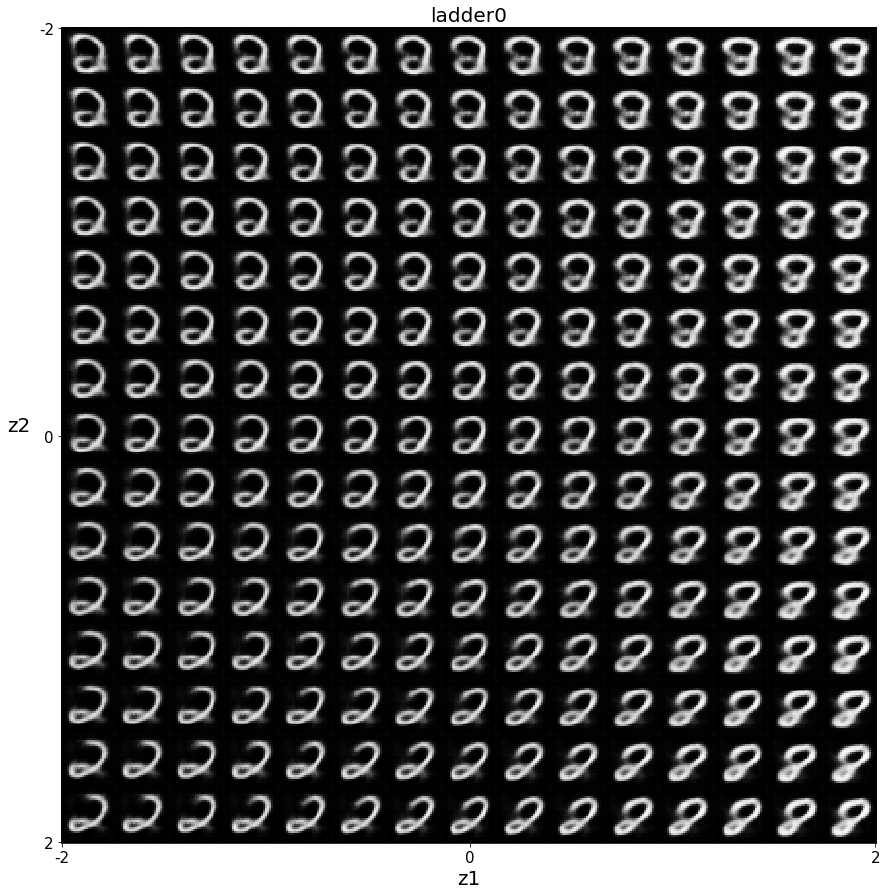

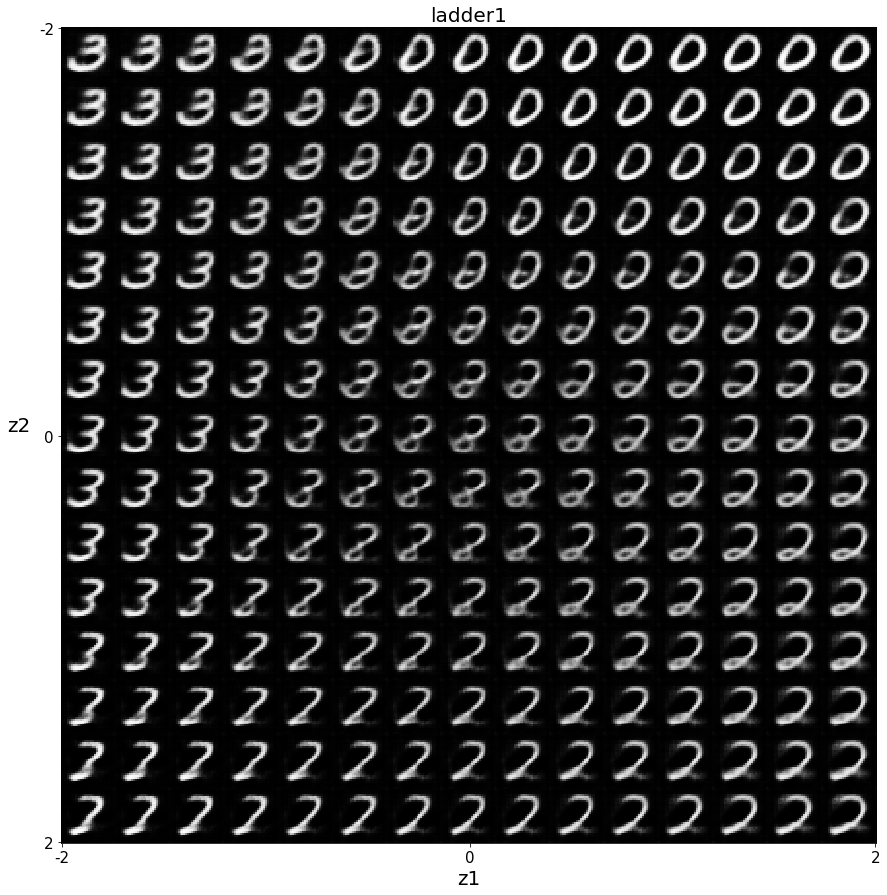

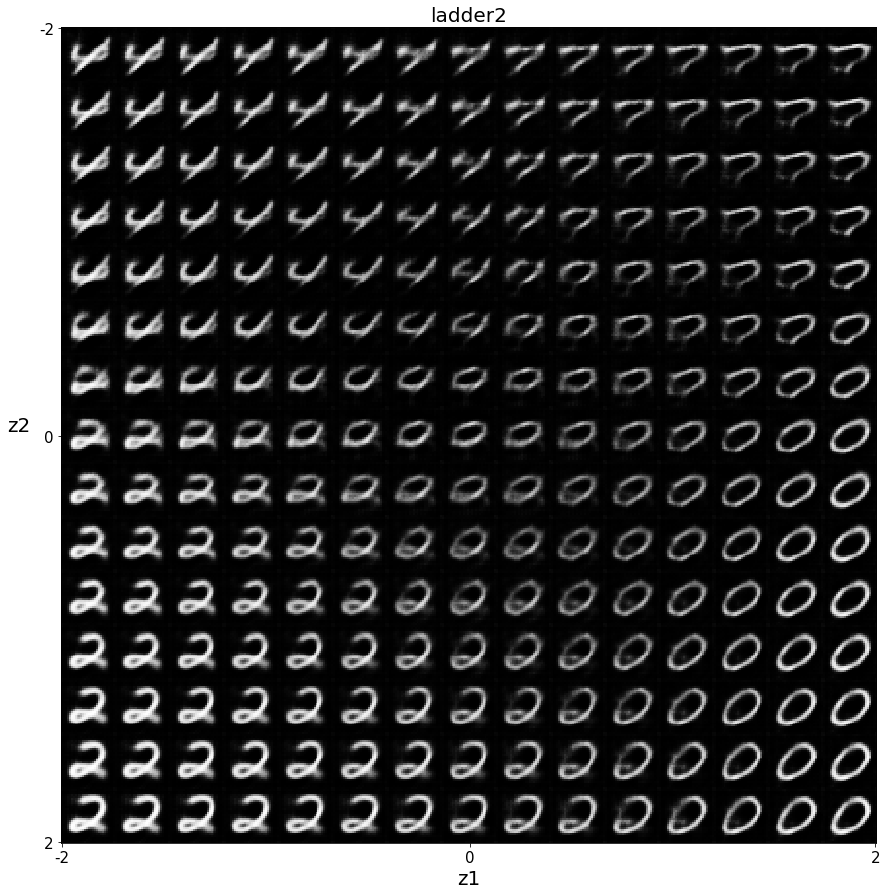

In [4]:
# Due to batch norm, we need to use a large of batch even when we're only trying to generate a single sample
# This is not a good practice and generally should not be done. I was having trouble getting population
# statistics to work for batch norm, so this is a quick workaround.
output, codes = model.generate_samples()
codes_index = 6

codes['ladder2'][codes_index] = [0, 1.8]
codes['ladder1'][codes_index] = [1.8, 0]
codes['ladder0'][codes_index] = [0, 0]
canvas = visualize_manifold('ladder0', codes_index)

codes['ladder2'][codes_index] = [0, 1.8]
codes['ladder1'][codes_index] = [0, 0]
codes['ladder0'][codes_index] = [-1, 1]
canvas = visualize_manifold('ladder1', codes_index)

codes['ladder2'][codes_index] = [0, 1.8]
codes['ladder1'][codes_index] = [1.8, 0]
codes['ladder0'][codes_index] = [-1, 1]
canvas = visualize_manifold('ladder2', codes_index)


#visualize_manifold('ladder0', codes_index)
#visualize_manifold('ladder1', codes_index)
#visualize_manifold('ladder2', codes_index)

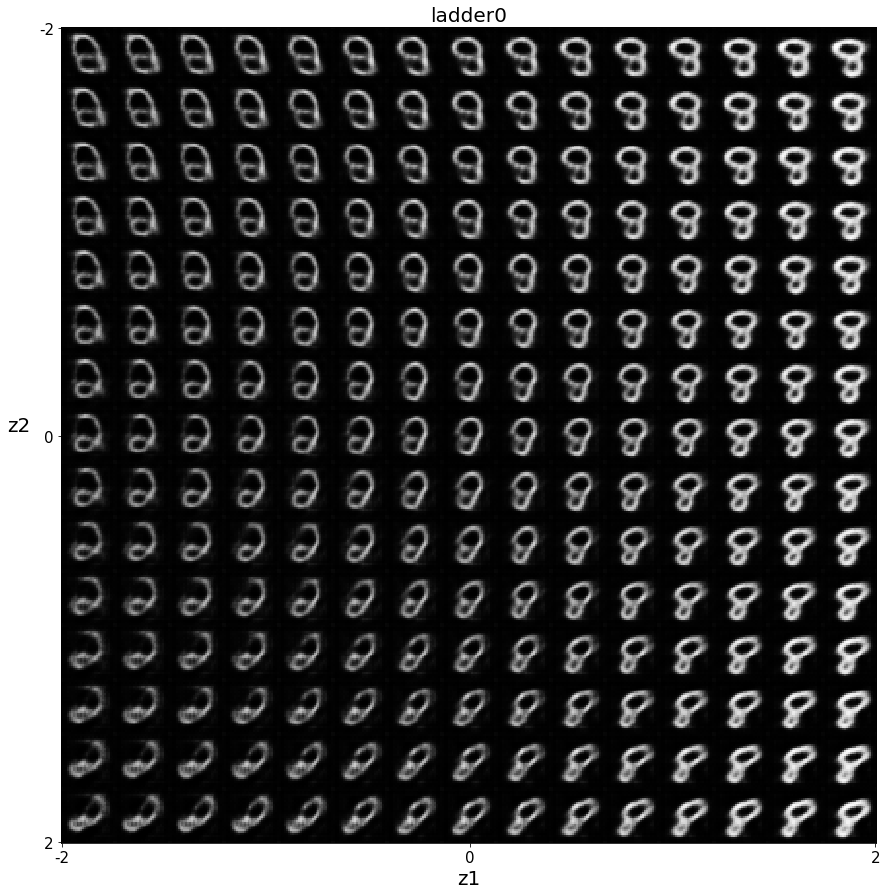

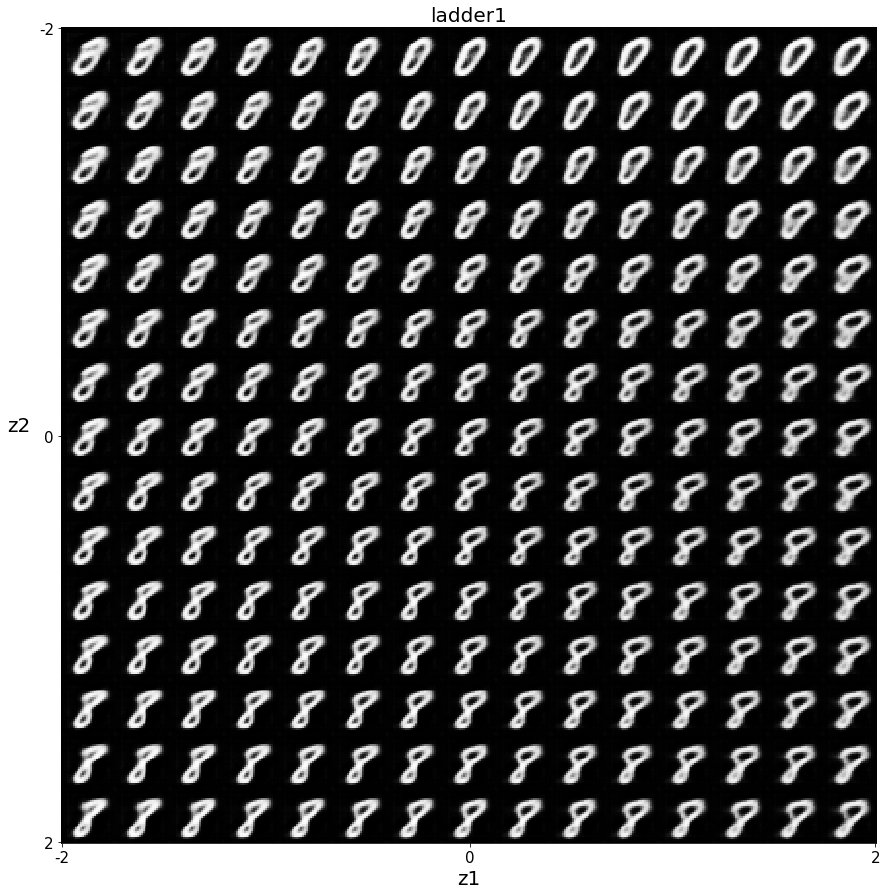

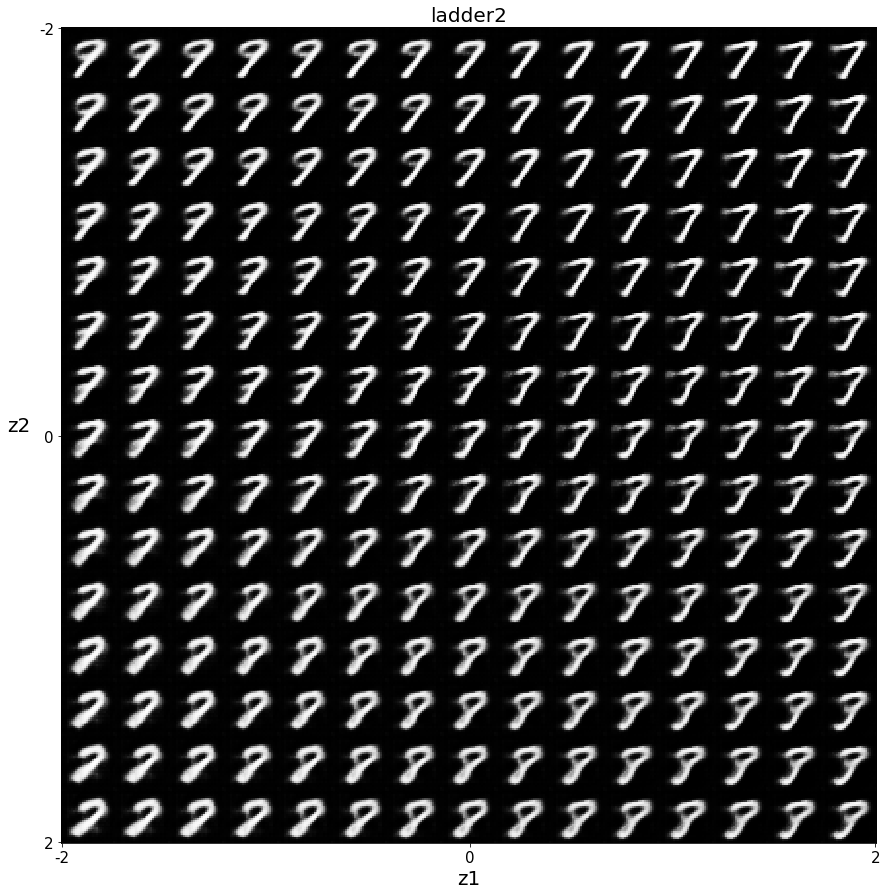

In [14]:
# Due to batch norm, we need to use a large of batch even when we're only trying to generate a single sample
# This is not a good practice and generally should not be done. I was having trouble getting population
# statistics to work for batch norm, so this is a quick workaround.
output, codes = model.generate_samples()
codes_index = 6

codes['ladder2'][codes_index] = [0, 1.8]
codes['ladder1'][codes_index] = [1.8, 0]
codes['ladder0'][codes_index] = [0, 0]

visualize_manifold('ladder0', codes_index)
visualize_manifold('ladder1', codes_index)
visualize_manifold('ladder2', codes_index)

In [ ]:
output, codes = model.generate_samples()
#feed_dict = {model.ladders[key][0]: np.expand_dims(code[key], 0) for key in code}

#x_gen = model.sess.run(model.goutput, feed_dict)
for i in range(output.shape[0]):    
    plt.imshow(np.squeeze(output[i]))
    plt.show()

In [ ]:
layers = [layer for layer in model.random_latent_code()]
layers.sort()
for layer in layers:
    print layer

## The end

In [ ]:
x = dataset.next_batch(200)
ladder0, ladder1, ladder2 = model.sess.run([model.iladder0_mean, model.iladder1_mean, model.iladder2_mean], feed_dict={model.input_placeholder: x,
                                                 model.is_training: True})

x_gen = model.sess.run(model.goutput, feed_dict={model.ladder0_placeholder: ladder0,
                                                 model.ladder1_placeholder: ladder1,
                                                 model.ladder2_placeholder: ladder2})


for i in range(x.shape[0]):
    print(str(i))
    plt.imshow(np.squeeze(x[i]))
    plt.show()
    plt.imshow(np.squeeze(x_gen[i]))
    plt.show()